In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 29 21:39:37 2023

@author: Bebesi Laci
"""

import sys
import os
import pandas as pd
import numpy as np
import logging
from tqdm import tqdm
import statsmodels.api as sm
import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


sys.path.insert(0, r"K:/Thesis/codes/crypto_project")
sys.path.insert(0, r"E:/Thesis/crypto_project")
from factor_model.model_update.loaders.crypto_coin_loaders import get_extended_ticker_list
from factor_model.model_update.loaders.price_data_loaders import (
    generate_ytickets,
    generate_price_data_map,
)
from factor_model.model_update.loaders.market_cap_loader import (
    generate_market_cap_data,
    generate_market_cap_only,
)
from factor_model.model_update.loaders.crypto_coin_loaders import get_ticker_list, get_extended_ticker_list
from statsmodels.stats.outliers_influence import variance_inflation_factor

from factor_model.model_update.return_generators.total_return_calculation import (
    generate_return_data,
)
from datetime import date, timedelta
from factor_model.model_update.database_generators.generate_databases import (
    refresh_database,
)
from factor_model.model_update.estimation_universe.estimation_core_universe import (
    generate_estimation_basis,
)
from factor_model.model_update.styles.return_based import (
    generate_x_month_price_change,
)
from factor_model.model_update.styles.volume_based import (
    generate_x_month_aggregate_volume,
)
from factor_model.model_update.factor_return_estimation.factor_return_estimation import (
    create_factor_return_data,
)
from factor_model.model_update.loaders.risk_free_rate_loader import get_risk_free_rate_history
from factor_model.model_update.return_generators.excess_return_calculation import generate_excess_returns

DATABASE_LOCATION = r"E:/Thesis/database"
from factor_model.model_update.database_generators import (
    RAW_DATA_DB,
    RETURN_DB,
    FACTOR_MODEL_ESTIMATES
)


In [2]:

parameters = {
    "HORIZON" : "15y",
    "ESTIMATION_HORIZON": int(7.5*365),
    "WEIGHT_FUNCTION" : np.sqrt,
    "PRESENT_IN_MARKET" : 3*365,  # trade days, 3 years approx
    "ESTIMATION_DAY": date.today(),
    "MARKET_CAP_COVERAGE" : 0.90,
    "NEW_COIN_INCLUSION": 120,  # after X days
    "REGRESSORS_SET1": ["market", "size", "momentum", "reversal", "volume", "new_coin"],
    "REGRESSORS_SET2": [],
    "MONTH_LENGTH": 30,
    "GENERATE_DATABASE": True
}
parameters["CORE_UNIV_START"] = parameters["ESTIMATION_DAY"] - timedelta(parameters["PRESENT_IN_MARKET"])


##### 1. Grab the list of tickers

In [32]:
tickers = get_extended_ticker_list(3000)  # the number of crypto can be adjusted...
# TODO : survival bias should be fixed by adding discontiued crypto currency
tickers = [f for f in tickers if f.endswith("USD")]
tickers = sorted(list(set(tickers)))

##### 2. Load Crypto Historical data

In [33]:
yfinance_tickers = generate_ytickets(tickers)
price_data_map, tickers_with_missing_data = generate_price_data_map(yfinance_tickers, parameters["HORIZON"])

problematic_keys = []
for key in price_data_map.keys():
    if len(price_data_map[key].columns) > 8:
        problematic_keys.append(key)

for key in problematic_keys:
    del price_data_map[key]

if parameters["GENERATE_DATABASE"]:
    refresh_database(
        symbol_level_data=price_data_map,
        database_location=DATABASE_LOCATION,
        database_name=RAW_DATA_DB,
        database_table_name="raw_price_data",
        delete_database = parameters["GENERATE_DATABASE"]
    )

# refresh tickers and throw out those ones, which have no price history
drop_keys = list()
for key in price_data_map.keys():
    if len(price_data_map[key]) < 2:  # minimum number of obs for returns are 2
        del yfinance_tickers[key]
        drop_keys.append(key)
for key in drop_keys:
    del price_data_map[key]


##### 3. Get market capitalization

In [36]:
# market_cap_df_full = generate_market_cap_data(yfinance_tickers)
market_cap_df = generate_market_cap_only(yfinance_tickers)
# generate square root of cap weighting
market_cap_df["transformed_market_cap"] = parameters["WEIGHT_FUNCTION"](market_cap_df["market_cap"])
market_cap_df.sort_values(by = "transformed_market_cap", ascending=False, inplace=True)


2024-09-08 14:38:26,970 - INFO - No data for ticker: 50X-USD
2024-09-08 14:38:27,577 - INFO - No data for ticker: A2A-USD
2024-09-08 14:38:30,778 - INFO - No data for ticker: ADO-USD
2024-09-08 14:38:31,939 - INFO - No data for ticker: AET28981-USD
2024-09-08 14:38:33,538 - INFO - No data for ticker: AI14838-USD
2024-09-08 14:38:34,163 - INFO - No data for ticker: AIDOGEX-USD
2024-09-08 14:38:34,286 - INFO - No data for ticker: AIE-USD
2024-09-08 14:38:39,676 - INFO - No data for ticker: AMT23499-USD
2024-09-08 14:38:40,138 - INFO - No data for ticker: ANDY20-USD
2024-09-08 14:38:40,491 - INFO - No data for ticker: ANIMA-USD
2024-09-08 14:38:41,956 - INFO - No data for ticker: APEX31588-USD
2024-09-08 14:38:43,057 - INFO - No data for ticker: APTOGE-USD
2024-09-08 14:38:43,795 - INFO - No data for ticker: ARB-USD
2024-09-08 14:38:47,962 - INFO - No data for ticker: ATK-USD
2024-09-08 14:38:49,512 - INFO - No data for ticker: AURA31843-USD
2024-09-08 14:38:53,396 - INFO - No data for ti

##### 4. Calculate total and excess returns + align estimation dates

In [38]:
total_return_data_map = generate_return_data(price_data_map)


E:\Thesis/crypto_project\factor_model\model_update\return_generators\total_return_calculation.py:9: RuntimeWarning: divide by zero encountered in true_divide
  gg = np.matrix(price_data_map[key]["Close"].diff().tail(-1)) / np.matrix(
E:\Thesis/crypto_project\factor_model\model_update\return_generators\total_return_calculation.py:9: RuntimeWarning: invalid value encountered in true_divide
  gg = np.matrix(price_data_map[key]["Close"].diff().tail(-1)) / np.matrix(


In [39]:
estimation_dates=list(total_return_data_map["BTC-USD"].tail(parameters["ESTIMATION_HORIZON"])["date"])
estimation_dates = list(
    total_return_data_map["ETC-USD"].tail(parameters["ESTIMATION_HORIZON"])["date"]
)
estimation_dates = [
    date_value
    for date_value in estimation_dates
    if date_value > datetime.date(2018, 5, 8)
]  # six months after ETH-USD has data in yfinance


In [40]:
# risk free rates and excess returns
risk_free_rate_data = get_risk_free_rate_history(estimation_dates)
excess_return_data_map = generate_excess_returns(
    total_return_data_map, risk_free_rate_data
)
if parameters["GENERATE_DATABASE"]:
    refresh_database(
        symbol_level_data=excess_return_data_map,
        database_location=DATABASE_LOCATION,
        database_name=RETURN_DB,
        database_table_name="returns",
        delete_database=True
    )
    refresh_database(
        symbol_level_data={"SOFR/Treasury-3M": risk_free_rate_data},
        database_location=DATABASE_LOCATION,
        database_name=RETURN_DB,
        database_table_name="risk_free_rates",
        delete_database=False
    )

[*********************100%%**********************]  1 of 1 completed
2024-09-08 14:45:03,869 - INFO - First SOFR date is 2018-04-30 00:00:00, before this date, the 3M US Treasury rate is used as risk free rate.
2024-09-08 14:45:03,877 - INFO - 3M US Treasury rate is used for 3349 trading days.


##### 5. Style generation

In [41]:
momentum_move_map = generate_x_month_price_change(price_data_map,  x_len = 6, month_len = parameters["MONTH_LENGTH"])
reversal_map = generate_x_month_price_change(price_data_map,  x_len = 1, month_len = parameters["MONTH_LENGTH"])
volume_map = generate_x_month_aggregate_volume(price_data_map,  x_len = 1, month_len = parameters["MONTH_LENGTH"])
daily_data_maps = {}
daily_data_maps["reversal"] = reversal_map
daily_data_maps["momentum"] = momentum_move_map
daily_data_maps["return"] = excess_return_data_map
daily_data_maps["volume"] = volume_map


E:\Thesis/crypto_project\factor_model\model_update\styles\return_based.py:22: RuntimeWarning: divide by zero encountered in true_divide
  close_price_changes = np.matrix(
E:\Thesis/crypto_project\factor_model\model_update\styles\return_based.py:22: RuntimeWarning: invalid value encountered in true_divide
  close_price_changes = np.matrix(


In [42]:
tstats_all = list()
coefficients_all = list()
vif_all = list()
model_summary = list()
try:
    os.remove(os.path.join(DATABASE_LOCATION, FACTOR_MODEL_ESTIMATES))
except Exception:
    pass

for date in tqdm(estimation_dates):
    # step 0 : assemble and save estimation data
    estimation_basis, _ = generate_estimation_basis(
        excess_return_data_map, market_cap_df, date, parameters
    )
    factor_return_data = create_factor_return_data(
        estimation_basis, parameters, date, daily_data_maps
    )
    factor_return_data_core = factor_return_data[
        factor_return_data["core_universe"] > 0
    ]
    if parameters["GENERATE_DATABASE"]:
        refresh_database(
            symbol_level_data={str(date): factor_return_data.rename(columns={"ticker": "symbol"})},
            database_location=DATABASE_LOCATION,
            database_name=FACTOR_MODEL_ESTIMATES,
            database_table_name="exposures",
            delete_database=False,
            key_field_name="date",
            update_mode="append",
        )
    # step 1 estimation
    try:
        mod_wls = sm.WLS(
            endog=factor_return_data_core["return"],
            exog=factor_return_data_core[parameters["REGRESSORS_SET1"]],
            weights=factor_return_data_core["transformed_market_cap"],
        ).fit()

        # step 2 save results
        coefficient_date = mod_wls.params.to_frame().T
        coefficient_date["date"] = date
        coefficients_all.append(coefficient_date)

        tstat_date = mod_wls.tvalues.to_frame().T
        tstat_date["date"] = date
        tstats_all.append(tstat_date)

        model_summary.append(
            pd.DataFrame(
                {
                    "date": [date],
                    "r2_core": [mod_wls.rsquared],
                    "r2_adj": [mod_wls.rsquared_adj],
                    "nobs": [mod_wls.nobs],
                }
            )
        )

        exog = factor_return_data[
            parameters["REGRESSORS_SET1"] + parameters["REGRESSORS_SET2"]
        ].to_numpy()
        num_features = exog.shape[1]
        vif_values = [variance_inflation_factor(exog, i) for i in range(num_features)]
        vif_result_date = (
            pd.Series(
                vif_values,
                index=parameters["REGRESSORS_SET1"] + parameters["REGRESSORS_SET2"],
            )
            .to_frame()
            .T
        )
        vif_result_date["date"] = date
        vif_all.append(vif_result_date)

        specific_returns = factor_return_data[["ticker"]].copy()
        specific_returns["specific_return"] = factor_return_data["return"]-mod_wls.predict(factor_return_data[parameters["REGRESSORS_SET1"]])
        if parameters["GENERATE_DATABASE"]:
            refresh_database(
                symbol_level_data={str(date): specific_returns.rename(columns={"ticker": "symbol"})},
                database_location=DATABASE_LOCATION,
                database_name=FACTOR_MODEL_ESTIMATES,
                database_table_name="specific_returns",
                delete_database=False,
                key_field_name="date",
                update_mode="append",
            )
    except Exception:
        print(date)

  0%|          | 0/2315 [00:00<?, ?it/s]

100%|██████████| 2315/2315 [7:00:29<00:00, 10.90s/it]     


In [43]:
all_tstat = pd.concat(tstats_all, axis = 0)
all_coeff = pd.concat(coefficients_all, axis = 0)
all_vif = pd.concat(vif_all, axis = 0)
all_model_summary = pd.concat(model_summary, axis = 0)
if parameters["GENERATE_DATABASE"]:
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_tstat},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="t_statistics",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
        drop_id_col=True
    )
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_coeff},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="factor_returns",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
        drop_id_col=True
    )
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_vif},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="vifs",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
        drop_id_col=True
    )
    refresh_database(
        symbol_level_data={str(datetime.date.today()): all_model_summary},
        database_location=DATABASE_LOCATION,
        database_name=FACTOR_MODEL_ESTIMATES,
        database_table_name="r_squares",
        delete_database=False,
        key_field_name="version_date",
        update_mode="append",
        drop_id_col=True
    )

##### 6. Analysis and sanity checks

In [44]:
print("Active T-stat ratios")
for style in parameters['REGRESSORS_SET1']:
    active_stat = sum(abs(all_tstat[style])>2)/len(all_tstat)
    active_stat = np.round(active_stat,3)
    print(f" {style} : {active_stat}.")
    
for style in parameters['REGRESSORS_SET1']:
    all_coeff[style+"_cumprod"] = (all_coeff[style] +1 ).cumprod()
    
print("Problematic VIF ratios (VIF higher than 5)")
for style in parameters['REGRESSORS_SET1']:
    problematic_vif = sum(abs(all_vif[style])>2)/len(all_vif)
    problematic_vif = np.round(problematic_vif,3)
    print(f" {style} : {problematic_vif}.")

Active T-stat ratios
 market : 0.837.
 size : 0.273.
 momentum : 0.347.
 reversal : 0.444.
 volume : 0.323.
 new_coin : 0.24.
Problematic VIF ratios (VIF higher than 5)
 market : 1.0.
 size : 0.0.
 momentum : 0.0.
 reversal : 0.0.
 volume : 0.0.
 new_coin : 0.0.


In [45]:
all_tstat2 = all_tstat.copy()
for style in parameters['REGRESSORS_SET1']:
    all_tstat2[style] = abs(all_tstat2[style])
all_tstat2.describe()

,market,size,momentum,reversal,volume,new_coin
count,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000,2315.000000
mean,9.825683,1.491233,1.814835,2.351837,1.662326,1.382993
std,8.997743,1.272912,1.614556,2.232503,1.398052,1.114493
min,0.014782,0.000206,0.001448,0.000440,0.000113,0.000691
25%,3.242983,0.542250,0.657871,0.833029,0.605102,0.518328
50%,7.387387,1.171863,1.396125,1.726735,1.326196,1.140826
75%,13.639317,2.105154,2.497813,3.131125,2.335014,1.952207
max,59.052430,9.099934,13.568311,18.461879,8.283327,8.067918


In [46]:
all_model_summary.describe()

,r2_core,r2_adj,nobs
count,2315.000000,2315.000000,2315.000000
mean,0.106933,0.084117,409.500648
std,0.107983,0.101427,294.683176
min,0.001578,-0.061311,43.000000
25%,0.034287,0.017515,137.000000
50%,0.069372,0.049310,332.000000
75%,0.140071,0.110772,679.000000
max,0.682527,0.655623,1029.000000


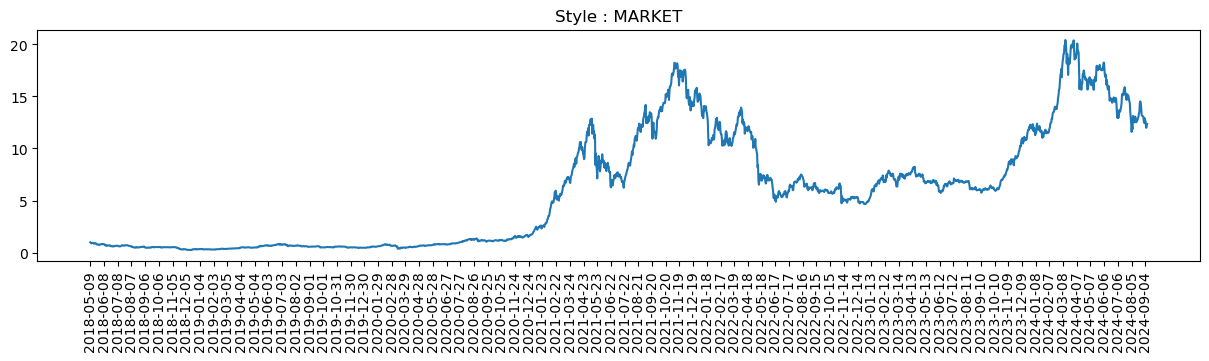

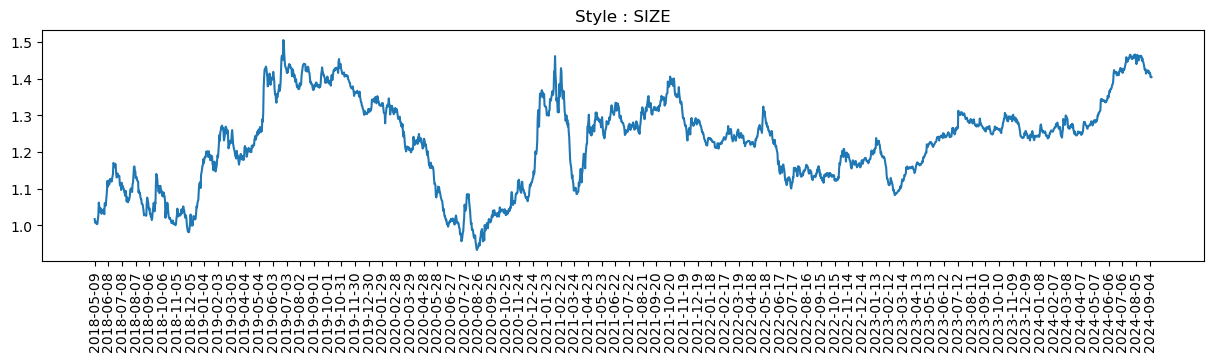

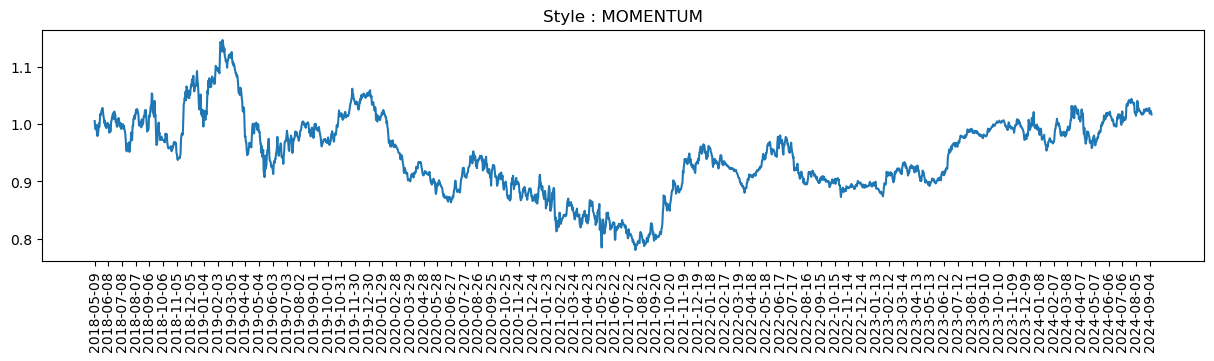

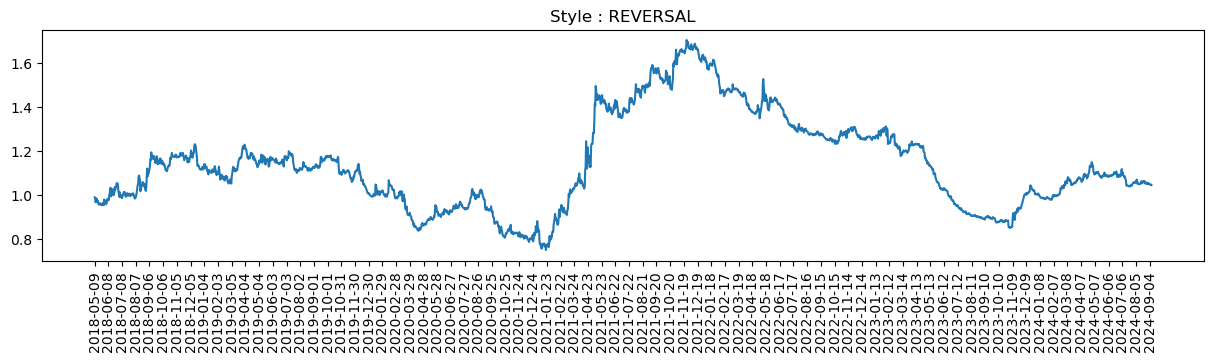

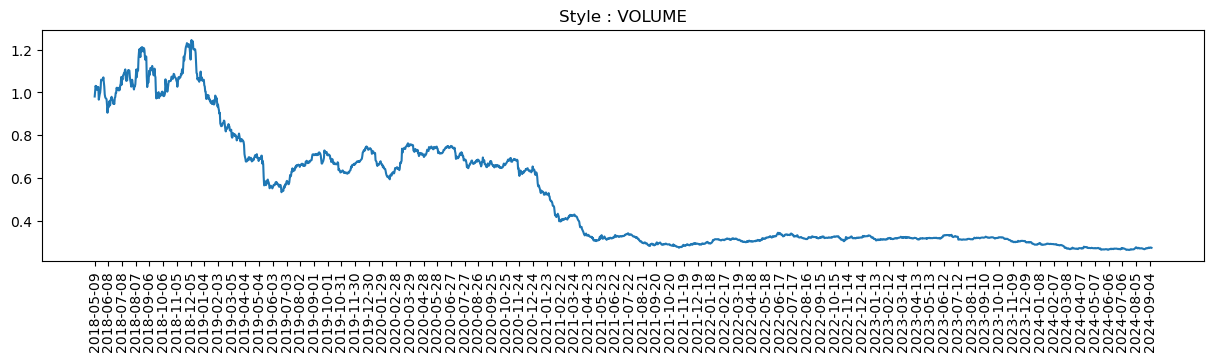

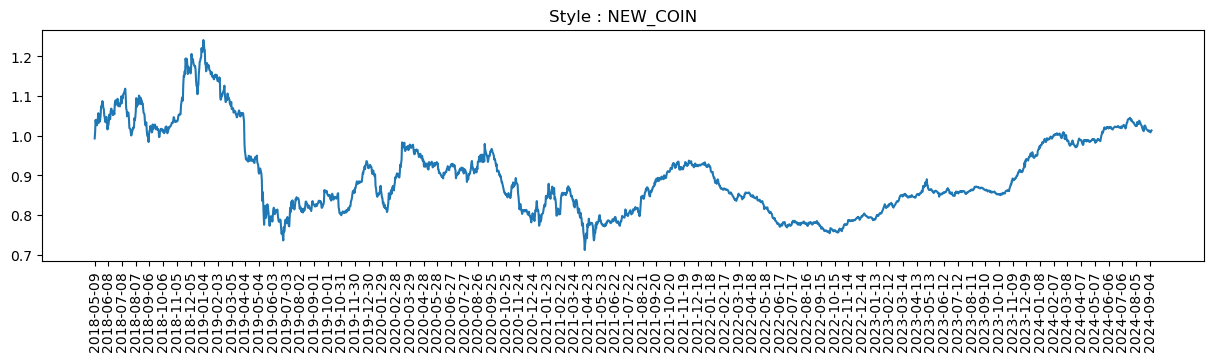

In [47]:
for style in parameters['REGRESSORS_SET1']:
    plt.figure(figsize=(15,3))
    plt.plot(range(0, len(all_coeff)),all_coeff[style+"_cumprod"])
    plt.title(f"Style : {style.upper()}")
    plt.xticks(range(0,len(all_coeff),30), list(all_coeff["date"])[::30], rotation = 90)
    plt.savefig(f"E:\Thesis\stuff\{style}.png")
    plt.show()

In [49]:
all_coeff[parameters['REGRESSORS_SET1']].corr()

,market,size,momentum,reversal,volume,new_coin
market,1.000000,0.234172,0.079660,-0.075934,-0.708282,-0.369711
size,0.234172,1.000000,-0.081999,0.011961,-0.569412,0.019320
momentum,0.079660,-0.081999,1.000000,-0.257492,0.038225,0.093495
reversal,-0.075934,0.011961,-0.257492,1.000000,0.042692,0.064007
volume,-0.708282,-0.569412,0.038225,0.042692,1.000000,0.522644
new_coin,-0.369711,0.019320,0.093495,0.064007,0.522644,1.000000
